# Estimating the temperature & moisture thresholds for the tree growth

In this tutorial, we estimate the temperature & moisture thresholds for the tree growth in PAGES2k, utilizing VS-Lite.

In [1]:
%load_ext autoreload
%autoreload 2

import cfr
import pandas as pd
import numpy as np
import os
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

## Data preparation

### Proxy

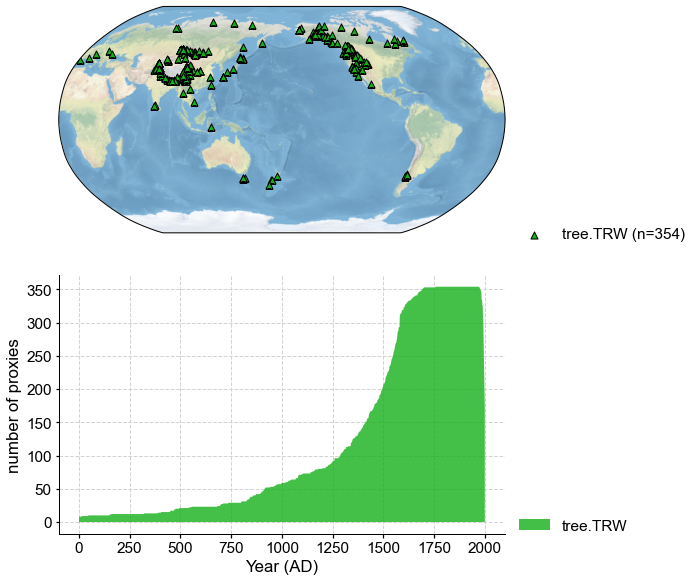

In [10]:
df = pd.read_pickle('./data/pages2k_dataset.pkl')
pdb = cfr.ProxyDatabase().from_df(df)
pdb_TRW = pdb.filter(by='ptype', keys=['TRW'])
fig, ax = pdb_TRW.plot()

### Instrumental observations

In [4]:
dirpath = '/Volumes/ExtraDrive/Data/Analyses/CRUTS'

obs_tas_ds = cfr.ClimateDataset().load_nc(os.path.join(dirpath, 'cru_ts4.05.1901.2020.tmp.dat.nc'), vn='tmp', load=True)
obs_pr_ds = cfr.ClimateDataset().load_nc(os.path.join(dirpath, 'cru_ts4.05.1901.2020.pre.dat.nc'), vn='pre', load=True)

In [5]:
obs_pr = obs_pr_ds.fields['pre'].rename('pr')
obs_tas = obs_tas_ds.fields['tmp'].rename('tas')

In [6]:
%%time
obs_tas_new = obs_tas.wrap_lon()

CPU times: user 5.9 s, sys: 1.36 s, total: 7.25 s
Wall time: 7.35 s


In [7]:
obs_tas_new.da.coords

Coordinates:
  * lon      (lon) float32 0.25 0.75 1.25 1.75 2.25 ... 358.2 358.8 359.2 359.8
  * lat      (lat) float32 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * time     (time) datetime64[ns] 1901-01-16 1901-02-15 ... 2020-12-16

In [8]:
obs_pr_new = obs_pr.wrap_lon()

In [9]:
obs_pr_new.da.coords

Coordinates:
  * lon      (lon) float32 0.25 0.75 1.25 1.75 2.25 ... 358.2 358.8 359.2 359.8
  * lat      (lat) float32 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * time     (time) datetime64[ns] 1901-01-16 1901-02-15 ... 2020-12-16

## Get climate data for `ProxyDatabase`

In [11]:
%%time

pdb_TRW.del_clim()
pdb_TRW.get_clim(obs_tas_new, tag='obs')
pdb_TRW.get_clim(obs_pr_new, tag='obs')

Getting the nearest climate for ProxyRecord: 100%|██████████| 354/354 [09:25<00:00,  1.60s/it]

CPU times: user 31min 58s, sys: 16.5 s, total: 32min 15s
Wall time: 32min 35s


In [12]:
pdb_TRW.records['NAm_153'].clim['obs_tas'].da

<xarray.DataArray 'tas' (time: 1440)>
array([-12.       , -11.7      ,  -5.8      , ...,  -1.2      ,
        -7.2000003,  -7.8      ], dtype=float32)
Coordinates:
    lon      float32 241.8
    lat      float32 52.75
  * time     (time) datetime64[ns] 1901-01-16 1901-02-15 ... 2020-12-16
Attributes:
    long_name:                   near-surface temperature
    units:                       degrees Celsius
    correlation_decay_distance:  1200.0

In [13]:
pd.to_pickle(pdb_TRW, './data/pdb_TRW_clim.pkl')

## Create a PSM object

In [2]:
pdb_TRW = pd.read_pickle('./data/pdb_TRW_clim.pkl')

In [3]:
%%time
mdl = {}
for pid, pobj in tqdm(pdb_TRW.records.items(), total=pdb_TRW.nrec):
    mdl[pid] = cfr.psm.VSLite(pobj)
    try:
        mdl[pid].calibrate()
        pd.to_pickle(mdl[pid], f'./data/VSL_mdls/TRW_VSL_PSMs_{pid}.pkl')
    except:
        pass

  0%|          | 0/354 [00:00<?, ?it/s]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0103   1.0023   0.9998   1.0050   1.2649
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


  0%|          | 1/354 [00:39<3:51:50, 39.41s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   0.9993   1.0006   0.9990   1.0022   1.0772


  1%|          | 2/354 [01:15<3:38:43, 37.28s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0011   0.9990   0.9992   1.0002   1.7804
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


  1%|          | 3/354 [01:50<3:33:06, 36.43s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   0.9994   1.0032   1.0068   1.0090   1.0657


  1%|          | 4/354 [02:26<3:32:20, 36.40s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0006   0.9994   0.9996   1.0011   1.2797
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


  1%|▏         | 5/354 [03:03<3:31:15, 36.32s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0035   1.0038   1.0004   1.0083   1.1476
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


  2%|▏         | 6/354 [03:40<3:32:08, 36.58s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0047   1.0308   1.0010   1.0028   1.6520
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


  2%|▏         | 7/354 [04:16<3:30:42, 36.43s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0021   0.9996   1.0005   1.0005   1.3998
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


  2%|▏         | 8/354 [04:52<3:28:49, 36.21s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0054   1.0001   0.9992   1.0046   1.4287
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


  3%|▎         | 9/354 [05:28<3:28:58, 36.34s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0104   1.0126   0.9993   1.0344   1.0468


  3%|▎         | 10/354 [06:03<3:26:18, 35.98s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0834   1.0007   1.0002   1.0041   1.1007
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


  3%|▎         | 11/354 [06:39<3:24:17, 35.74s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0063   1.0135   1.0007   1.0001   1.1418
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


  3%|▎         | 12/354 [07:15<3:24:26, 35.87s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0341   1.1542   1.0232   1.2108   1.0503
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


  4%|▎         | 13/354 [07:51<3:24:28, 35.98s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0038   1.0000   0.9999   1.0068   1.1476
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


  4%|▍         | 14/354 [08:28<3:24:53, 36.16s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0044   1.0013   1.0049   1.0017   1.0597


  4%|▍         | 15/354 [09:03<3:23:48, 36.07s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0003   1.0035   1.0034   1.0015   1.1676
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


  5%|▍         | 16/354 [09:39<3:22:37, 35.97s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0021   0.9994   1.0008   1.0003   1.3524
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


  5%|▍         | 17/354 [10:15<3:21:04, 35.80s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0021   1.0002   1.0000   1.0012   1.3998
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


  5%|▌         | 18/354 [10:51<3:20:46, 35.85s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0036   0.9999   1.0060   1.0059   1.1074
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


  5%|▌         | 19/354 [11:27<3:20:23, 35.89s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0203   1.0011   0.9989   1.0013   8.4193
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


  6%|▌         | 20/354 [12:02<3:18:29, 35.66s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0114   1.0016   0.9995   1.0001   2.5552
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


  6%|▌         | 21/354 [12:37<3:17:14, 35.54s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0125   1.0033   1.0015   1.0013   1.0534


  6%|▌         | 22/354 [13:12<3:16:40, 35.54s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0318   0.9999   0.9995   0.9992   5.3272
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


  6%|▋         | 23/354 [13:48<3:16:26, 35.61s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0148   0.9989   1.0029   0.9997   1.2689
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


  7%|▋         | 24/354 [14:25<3:17:01, 35.82s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0408   1.0014   0.9992   0.9996   1.3875
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


  7%|▋         | 25/354 [15:00<3:16:37, 35.86s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0016   1.0006   1.0061   1.0002   1.2766
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


  7%|▋         | 26/354 [15:36<3:15:51, 35.83s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0098   1.0021   0.9990   1.0293   1.2535
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


  8%|▊         | 27/354 [16:12<3:15:40, 35.90s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0030   1.0011   1.0015   1.0053   1.6612
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


  8%|▊         | 28/354 [16:47<3:12:53, 35.50s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   0.9998   0.9993   1.0000   1.0035   1.0277


  8%|▊         | 29/354 [17:23<3:13:45, 35.77s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0019   0.9999   1.0003   1.0000   1.9697
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


  8%|▊         | 30/354 [17:58<3:11:22, 35.44s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0163   1.0035   1.0034   1.0062   1.1095
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


  9%|▉         | 31/354 [18:34<3:12:01, 35.67s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0044   1.0003   0.9998   0.9990   1.7454
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


  9%|▉         | 32/354 [19:10<3:11:52, 35.75s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0017   1.0011   1.0006   1.0028   1.2687
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


  9%|▉         | 33/354 [19:47<3:12:41, 36.02s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0023   1.0024   1.0060   1.0068   1.2525
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 10%|▉         | 34/354 [20:21<3:09:37, 35.55s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0035   0.9992   1.0003   1.0018   1.2677
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 10%|▉         | 35/354 [20:52<3:00:42, 33.99s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0041   1.0012   1.0004   1.0006   1.2716
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 10%|█         | 36/354 [21:22<2:54:45, 32.97s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.1396   1.1463   1.0388   1.2866   1.3758
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 10%|█         | 37/354 [21:53<2:50:50, 32.33s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   0.9994   1.0031   1.0045   0.9998   1.2268
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 11%|█         | 38/354 [22:24<2:48:08, 31.93s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0015   1.0000   0.9992   1.0024   1.2705
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 11%|█         | 39/354 [22:54<2:45:19, 31.49s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0087   1.0005   1.0004   1.0018   1.3176
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 11%|█▏        | 40/354 [23:24<2:42:28, 31.05s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0011   1.0040   1.0017   1.0022   1.2782
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 12%|█▏        | 41/354 [23:55<2:40:48, 30.83s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0086   1.0258   1.0029   1.0676   1.0433


 12%|█▏        | 42/354 [24:26<2:41:07, 30.98s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0009   1.0226   1.0019   1.0008   1.0586


 12%|█▏        | 43/354 [24:57<2:39:56, 30.86s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0014   1.0019   1.0008   1.0009   1.2767
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 12%|█▏        | 44/354 [25:27<2:39:00, 30.78s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0075   1.0052   1.0092   1.1487   1.0397
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 13%|█▎        | 45/354 [25:57<2:36:43, 30.43s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0133   1.0971   1.0633   1.3252   1.1271
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 13%|█▎        | 46/354 [26:28<2:37:05, 30.60s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0079   1.0105   0.9998   1.0218   1.3864
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 13%|█▎        | 47/354 [26:58<2:35:40, 30.42s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0002   0.9994   0.9999   1.0005   1.1003
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 14%|█▎        | 48/354 [27:28<2:35:03, 30.40s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0034   0.9993   1.0066   1.0007   1.3998
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 14%|█▍        | 49/354 [27:59<2:34:51, 30.46s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   0.9998   1.0119   1.0021   0.9993   8.1124
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 14%|█▍        | 50/354 [28:29<2:33:52, 30.37s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0003   1.0881   0.9994   1.0010   5.6728
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 14%|█▍        | 51/354 [28:59<2:33:07, 30.32s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0034   1.0059   1.0001   1.0042   1.0032


 15%|█▍        | 52/354 [29:30<2:33:06, 30.42s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   0.9996   1.0035   0.9993   0.9993   1.9427
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 15%|█▍        | 53/354 [30:00<2:32:06, 30.32s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0037   1.0005   1.0065   1.0394   1.1271
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 15%|█▌        | 54/354 [30:31<2:32:12, 30.44s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   0.9997   1.0012   1.0022   1.0034   1.0186


 16%|█▌        | 55/354 [31:01<2:31:56, 30.49s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0006   0.9990   1.0021   1.0028   1.2001
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 16%|█▌        | 56/354 [31:32<2:32:08, 30.63s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   0.9997   0.9997   1.0008   1.0222   1.2049
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 16%|█▌        | 57/354 [32:03<2:31:20, 30.57s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0035   1.0008   1.0075   1.0075   1.0764


 16%|█▋        | 58/354 [32:32<2:29:34, 30.32s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0018   1.0006   1.0022   1.0021   1.2363
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 17%|█▋        | 59/354 [33:02<2:27:52, 30.08s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0017   0.9998   0.9991   1.0086   1.2486
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 17%|█▋        | 60/354 [33:33<2:28:23, 30.28s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0169   1.0026   1.0116   1.0154   1.0351


 17%|█▋        | 61/354 [34:02<2:26:59, 30.10s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0063   1.0027   0.9993   1.0068   1.1213
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 18%|█▊        | 62/354 [34:32<2:26:23, 30.08s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0060   1.0025   0.9997   1.0019   1.1574
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 18%|█▊        | 63/354 [35:03<2:26:12, 30.15s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0601   0.9991   0.9996   0.9996   8.4193
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 18%|█▊        | 64/354 [35:32<2:24:48, 29.96s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0045   1.0155   1.0077   1.0061   1.3965
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 18%|█▊        | 65/354 [36:03<2:24:57, 30.09s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0033   1.0293   0.9996   1.0029   1.3948
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 19%|█▊        | 66/354 [36:33<2:25:27, 30.30s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0022   1.0024   0.9997   0.9993   1.3670
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 19%|█▉        | 67/354 [37:04<2:25:24, 30.40s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0007   1.0064   0.9996   1.0018   1.2854
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 19%|█▉        | 68/354 [37:35<2:25:36, 30.55s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0007   1.0081   1.0091   1.0861   1.0220


 19%|█▉        | 69/354 [38:04<2:23:33, 30.22s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0082   1.0212   1.0093   1.0025   1.0674


 20%|█▉        | 70/354 [38:36<2:24:51, 30.60s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0061   1.0091   1.0026   1.0059   1.0614


 20%|██        | 71/354 [39:06<2:24:16, 30.59s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0026   0.9988   0.9998   1.0013   1.2764
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 20%|██        | 72/354 [39:37<2:23:46, 30.59s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0086   1.0009   1.0020   1.0008   1.3693
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 21%|██        | 73/354 [40:08<2:23:15, 30.59s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0296   1.0037   0.9993   0.9992   1.4007
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 21%|██        | 74/354 [40:39<2:23:16, 30.70s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0012   1.0341   1.0009   1.0034   1.0243


 21%|██        | 75/354 [41:09<2:22:01, 30.54s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0016   0.9993   1.0000   1.0002   1.3601
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 21%|██▏       | 76/354 [41:40<2:21:52, 30.62s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0008   1.0025   1.0013   0.9995   1.2596
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 22%|██▏       | 77/354 [42:10<2:21:47, 30.71s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0052   1.0010   0.9991   0.9991   1.2342
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 22%|██▏       | 78/354 [42:41<2:20:49, 30.62s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   0.9999   0.9997   1.0001   1.0000   1.0528


 22%|██▏       | 79/354 [43:12<2:20:54, 30.74s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0010   1.0022   1.0011   1.0036   1.2603
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 23%|██▎       | 80/354 [43:42<2:19:59, 30.65s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   0.9994   1.0136   0.9990   0.9992   2.9523
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 23%|██▎       | 81/354 [44:13<2:19:18, 30.62s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0080   1.0813   1.0023   1.0068   1.3957
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 23%|██▎       | 82/354 [44:44<2:19:23, 30.75s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0028   1.0043   1.0003   1.0130   1.2520
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 23%|██▎       | 83/354 [45:15<2:18:52, 30.75s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0013   0.9992   0.9996   1.0005   1.0689


 24%|██▎       | 84/354 [45:46<2:18:51, 30.86s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0013   1.0011   1.0002   1.0017   1.0095


 24%|██▍       | 85/354 [46:17<2:18:25, 30.87s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   0.9991   1.0335   1.0009   1.0055   1.1672
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 24%|██▍       | 86/354 [46:47<2:16:37, 30.59s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   0.9995   0.9995   1.0046   1.0015   1.0477


 25%|██▍       | 87/354 [47:17<2:15:39, 30.49s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0109   0.9989   0.9995   1.0012   1.3522
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 25%|██▍       | 88/354 [47:48<2:16:19, 30.75s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0018   1.0062   0.9997   1.0019   1.0351


 25%|██▌       | 89/354 [48:19<2:16:20, 30.87s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0045   0.9999   0.9996   1.0002   1.2718
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 25%|██▌       | 90/354 [48:50<2:15:04, 30.70s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0012   1.0012   1.0018   1.0073   1.2908
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 26%|██▌       | 91/354 [49:21<2:14:44, 30.74s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0092   1.0319   1.0116   1.0435   1.0315


 26%|██▌       | 92/354 [49:51<2:13:56, 30.68s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   0.9999   1.0010   0.9989   0.9997   1.1667
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 26%|██▋       | 93/354 [50:21<2:12:10, 30.39s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0175   1.0838   0.9988   1.0331   1.4028
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 27%|██▋       | 94/354 [50:51<2:11:52, 30.43s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0100   1.0036   1.0077   1.0002   1.0352


 27%|██▋       | 95/354 [51:21<2:10:14, 30.17s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0025   1.0035   1.0195   1.0803   1.0259


 27%|██▋       | 96/354 [51:51<2:10:18, 30.30s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0102   1.0779   1.0003   1.0217   1.3890
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 27%|██▋       | 97/354 [52:22<2:10:16, 30.42s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0158   1.0312   1.0024   1.0691   1.0513


 28%|██▊       | 98/354 [52:52<2:09:40, 30.39s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0006   1.0006   1.0034   1.0030   1.0270


 28%|██▊       | 99/354 [53:24<2:10:28, 30.70s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   0.9998   1.0027   1.0020   0.9997   1.0363


 28%|██▊       | 100/354 [53:54<2:09:17, 30.54s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0578   1.0000   1.0290   1.0271   1.0485


 29%|██▊       | 101/354 [54:24<2:08:07, 30.39s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0012   1.0005   1.0000   0.9996   1.0982


 29%|██▉       | 102/354 [54:55<2:07:51, 30.44s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0026   1.0022   0.9996   1.0035   1.3058
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 29%|██▉       | 103/354 [55:26<2:07:50, 30.56s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0022   0.9999   1.0001   1.0152   1.2222
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 29%|██▉       | 104/354 [55:56<2:07:50, 30.68s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0059   0.9995   1.0101   1.0098   1.0669


 30%|██▉       | 105/354 [56:27<2:07:06, 30.63s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0808   1.0028   1.2521   1.0172   1.2089
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 30%|██▉       | 106/354 [56:58<2:06:31, 30.61s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0024   1.0426   1.0003   1.0043   1.0118


 30%|███       | 107/354 [57:28<2:05:39, 30.53s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0005   1.0003   1.0034   1.0040   1.0148


 31%|███       | 108/354 [57:58<2:04:38, 30.40s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0024   1.0035   1.0043   1.0036   1.2289
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 31%|███       | 109/354 [58:29<2:05:26, 30.72s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0106   1.0066   0.9991   1.0016   1.0638


 31%|███       | 110/354 [59:00<2:04:47, 30.69s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0046   1.0131   0.9997   1.0014   1.3649
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 31%|███▏      | 111/354 [59:31<2:04:03, 30.63s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0030   1.0037   1.0051   1.0110   1.0278


 32%|███▏      | 112/354 [1:00:00<2:02:23, 30.35s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0060   1.1056   1.0122   1.0233   1.0165
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 32%|███▏      | 113/354 [1:00:31<2:02:30, 30.50s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0032   1.0016   1.0088   1.0079   1.0737


 32%|███▏      | 114/354 [1:01:02<2:02:08, 30.53s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0007   0.9999   0.9991   0.9990   1.2611
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 32%|███▏      | 115/354 [1:01:32<2:01:44, 30.56s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0033   1.0022   1.0023   1.0114   1.1614
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 33%|███▎      | 116/354 [1:02:03<2:01:09, 30.54s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0060   1.0073   0.9990   1.0086   1.2356
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 33%|███▎      | 117/354 [1:02:33<2:00:43, 30.56s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.2985   1.0194   1.1431   1.2277   1.1818
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 33%|███▎      | 118/354 [1:03:04<1:59:56, 30.49s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   0.9991   1.0059   1.0034   1.0074   1.0404


 34%|███▎      | 119/354 [1:03:34<1:59:25, 30.49s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0059   1.0014   0.9992   0.9996   1.1248
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 34%|███▍      | 120/354 [1:04:04<1:58:14, 30.32s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0262   0.9996   1.0006   1.0014   1.8953
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 34%|███▍      | 121/354 [1:04:35<1:58:18, 30.46s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   0.9999   0.9997   1.0013   1.0023   1.2679
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 34%|███▍      | 122/354 [1:05:05<1:57:41, 30.44s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0016   1.0012   1.0017   1.0034   1.2111
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 35%|███▍      | 123/354 [1:05:36<1:57:31, 30.52s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0046   1.0452   0.9994   0.9996   8.4193
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 35%|███▌      | 124/354 [1:06:07<1:57:19, 30.60s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0033   0.9999   1.0058   1.0005   1.2794
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 35%|███▌      | 125/354 [1:06:38<1:56:58, 30.65s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0448   1.0020   1.0005   1.0011   2.5796
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 36%|███▌      | 126/354 [1:07:07<1:55:22, 30.36s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0023   1.0012   1.0039   1.0036   1.1495
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 36%|███▌      | 127/354 [1:07:38<1:55:16, 30.47s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0219   1.1237   1.0060   1.2925   1.0873
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 36%|███▌      | 128/354 [1:08:09<1:55:15, 30.60s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0057   1.0007   1.0022   1.0004   1.2766
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 36%|███▋      | 129/354 [1:08:40<1:55:24, 30.78s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0021   0.9993   1.0012   1.0035   1.2413
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 37%|███▋      | 130/354 [1:09:11<1:54:57, 30.79s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   0.9999   1.0059   1.0061   1.0268   1.1804
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 37%|███▋      | 131/354 [1:09:42<1:54:16, 30.75s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.1421   1.1166   1.1221   1.2061   1.4150
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 37%|███▋      | 132/354 [1:10:13<1:53:57, 30.80s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0035   1.0013   0.9990   1.0124   1.1188
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 38%|███▊      | 133/354 [1:10:43<1:53:15, 30.75s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0041   1.0068   1.0026   1.0125   1.2564
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 38%|███▊      | 134/354 [1:11:14<1:52:56, 30.80s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0094   1.0016   0.9994   1.0011   1.9518
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 38%|███▊      | 135/354 [1:11:45<1:52:02, 30.70s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0021   1.0000   1.0004   0.9998   1.2868
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 38%|███▊      | 136/354 [1:12:16<1:51:52, 30.79s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   0.9997   1.0008   0.9995   1.0005   1.0654


 39%|███▊      | 137/354 [1:12:46<1:50:59, 30.69s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0208   0.9997   1.0000   0.9992   3.1158
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 39%|███▉      | 138/354 [1:13:16<1:50:03, 30.57s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0024   0.9999   0.9990   0.9991   1.0593


 39%|███▉      | 139/354 [1:13:47<1:49:44, 30.63s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0014   0.9997   1.0021   1.0009   1.2451
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 40%|███▉      | 140/354 [1:14:18<1:49:22, 30.66s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0033   1.0003   1.0001   1.0011   1.0429


 40%|███▉      | 141/354 [1:14:48<1:47:55, 30.40s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0299   0.9996   1.0009   0.9992   1.3874
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 40%|████      | 142/354 [1:15:18<1:47:37, 30.46s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0160   1.0206   1.0019   0.9990   1.1575
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 40%|████      | 143/354 [1:15:49<1:47:17, 30.51s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0153   1.0069   1.0064   1.0199   1.0102


 41%|████      | 144/354 [1:16:19<1:46:38, 30.47s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0056   1.0006   0.9990   1.0022   1.3998
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 41%|████      | 145/354 [1:16:49<1:45:56, 30.42s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0037   0.9990   1.0012   0.9998   1.1664
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 41%|████      | 146/354 [1:17:19<1:44:31, 30.15s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0030   1.0102   1.0095   1.0027   2.6884
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 42%|████▏     | 147/354 [1:17:48<1:42:29, 29.71s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0057   1.0020   0.9995   1.0013   1.0451


 42%|████▏     | 148/354 [1:18:18<1:42:39, 29.90s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0000   1.0768   1.0003   1.0186   1.0955


 42%|████▏     | 149/354 [1:18:48<1:42:43, 30.07s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0004   1.0002   1.0014   1.0015   1.1207
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 42%|████▏     | 150/354 [1:19:19<1:42:19, 30.10s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0014   1.0003   0.9994   1.0002   1.1034
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 43%|████▎     | 151/354 [1:19:49<1:41:46, 30.08s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0120   1.0563   1.0089   1.0339   1.3671
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 43%|████▎     | 152/354 [1:20:19<1:41:25, 30.13s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0010   1.0018   1.0005   1.0022   1.2656
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 43%|████▎     | 153/354 [1:20:50<1:41:25, 30.28s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0064   0.9991   0.9992   1.0032   1.3977
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 44%|████▎     | 154/354 [1:21:20<1:40:45, 30.23s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   0.9998   1.0176   1.0024   1.0046   1.3641
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 44%|████▍     | 155/354 [1:21:51<1:40:51, 30.41s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0102   1.0067   0.9991   1.0147   1.5951
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 44%|████▍     | 156/354 [1:22:21<1:40:17, 30.39s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   0.9997   0.9998   0.9990   1.0064   1.2585
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 44%|████▍     | 157/354 [1:22:51<1:40:00, 30.46s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   0.9999   0.9999   0.9998   1.0049   1.2748
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 45%|████▍     | 158/354 [1:23:22<1:39:50, 30.57s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   0.9994   1.0003   0.9992   1.0005   1.1030
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 45%|████▍     | 159/354 [1:23:53<1:39:00, 30.46s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0009   1.0018   0.9992   1.0051   1.0118


 45%|████▌     | 160/354 [1:24:23<1:38:25, 30.44s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0085   1.0246   1.0015   1.0053   6.7768
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 45%|████▌     | 161/354 [1:24:53<1:37:14, 30.23s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0058   1.0001   1.0005   0.9997   1.0611


 46%|████▌     | 162/354 [1:25:22<1:36:20, 30.11s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0051   1.0008   1.0000   0.9990   5.6728
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 46%|████▌     | 163/354 [1:25:53<1:36:00, 30.16s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0067   1.0011   0.9999   0.9989   1.3772
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 46%|████▋     | 164/354 [1:26:23<1:35:41, 30.22s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0000   1.0004   0.9995   1.0242   1.2519
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 47%|████▋     | 165/354 [1:26:53<1:35:07, 30.20s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   0.9997   1.0227   0.9999   1.0010   1.0503


 47%|████▋     | 166/354 [1:27:23<1:34:30, 30.16s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0006   1.0062   1.0004   1.0288   1.2704
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 47%|████▋     | 167/354 [1:27:54<1:34:21, 30.28s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0091   1.0194   1.0023   1.0209   1.3925
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 47%|████▋     | 168/354 [1:28:25<1:34:22, 30.45s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0043   0.9998   1.0010   0.9997   1.3685
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 48%|████▊     | 169/354 [1:28:55<1:33:58, 30.48s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0081   1.0139   1.0146   1.0220   1.1561
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 48%|████▊     | 170/354 [1:29:26<1:33:50, 30.60s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0029   1.0005   1.0001   1.0000   1.0398


 48%|████▊     | 171/354 [1:29:56<1:32:47, 30.42s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0052   1.0000   0.9996   0.9993   1.0780


 49%|████▊     | 172/354 [1:30:26<1:32:00, 30.33s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0054   1.0046   1.0005   1.0360   1.0451


 49%|████▉     | 173/354 [1:30:56<1:31:22, 30.29s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0095   0.9992   1.0018   1.0077   1.1337
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 49%|████▉     | 174/354 [1:31:27<1:30:41, 30.23s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0015   1.0008   1.0082   1.0126   1.0436


 49%|████▉     | 175/354 [1:31:57<1:30:29, 30.33s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   0.9996   1.0008   1.0012   1.0042   1.1390
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 50%|████▉     | 176/354 [1:32:27<1:29:54, 30.30s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0001   1.0008   1.0041   1.0028   1.2092
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 50%|█████     | 177/354 [1:32:58<1:29:43, 30.42s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0044   1.0045   1.0004   1.0009   1.2154
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 50%|█████     | 178/354 [1:33:29<1:29:34, 30.54s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0010   1.0009   1.0012   1.0148   1.0773


 51%|█████     | 179/354 [1:33:59<1:29:06, 30.55s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0013   0.9995   1.0008   1.0007   1.4872
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 51%|█████     | 180/354 [1:34:30<1:28:26, 30.50s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0061   1.0034   1.0038   1.0111   1.2324
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 51%|█████     | 181/354 [1:35:00<1:27:46, 30.44s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0010   1.0021   1.0023   0.9995   1.2520
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 51%|█████▏    | 182/354 [1:35:30<1:27:07, 30.39s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0218   1.0028   1.0011   1.0038   1.4167
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 52%|█████▏    | 183/354 [1:36:01<1:26:29, 30.35s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0035   1.0016   0.9993   1.0000   1.0151


 52%|█████▏    | 184/354 [1:36:31<1:25:48, 30.28s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   0.9991   1.0017   1.0021   1.1786   1.0328
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 52%|█████▏    | 185/354 [1:37:01<1:25:14, 30.26s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0086   0.9992   0.9997   1.0020   1.1617
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 53%|█████▎    | 186/354 [1:37:32<1:25:05, 30.39s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0033   1.0497   1.0011   1.0064   1.0831


 53%|█████▎    | 187/354 [1:38:02<1:24:39, 30.42s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0093   1.0051   1.0125   1.0027   1.8657
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 53%|█████▎    | 188/354 [1:38:32<1:23:57, 30.35s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0964   1.1268   1.0823   1.1877   1.3818
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 53%|█████▎    | 189/354 [1:39:03<1:23:45, 30.46s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0028   1.0059   1.0112   1.0604   3.1264
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 54%|█████▎    | 190/354 [1:39:32<1:21:54, 29.97s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0129   1.0028   1.0100   1.0009   1.0167


 54%|█████▍    | 191/354 [1:40:02<1:21:32, 30.01s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0079   1.0020   1.0010   0.9996   1.0692


 54%|█████▍    | 192/354 [1:40:32<1:21:09, 30.06s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0026   1.0028   1.0010   1.0021   1.3925
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 55%|█████▍    | 193/354 [1:41:03<1:20:52, 30.14s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0013   0.9992   1.0004   1.0064   1.2796
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 55%|█████▍    | 194/354 [1:41:33<1:20:38, 30.24s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0270   1.0269   1.0043   1.0183   1.0140


 55%|█████▌    | 195/354 [1:42:04<1:20:44, 30.47s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0001   0.9993   1.0015   0.9991   1.0455


 55%|█████▌    | 196/354 [1:42:34<1:19:48, 30.31s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0120   1.0050   1.0341   1.0004   1.3063
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 56%|█████▌    | 197/354 [1:43:04<1:19:22, 30.33s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0023   0.9995   1.0005   0.9992   1.1554
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 56%|█████▌    | 198/354 [1:43:36<1:19:31, 30.59s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0002   1.0021   1.0057   0.9999   1.0421


 56%|█████▌    | 199/354 [1:44:05<1:18:13, 30.28s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0041   0.9992   0.9989   1.0024   1.0124


 56%|█████▋    | 200/354 [1:44:35<1:17:36, 30.24s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   0.9991   1.0001   1.0007   1.0017   1.2483
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 57%|█████▋    | 201/354 [1:45:06<1:17:26, 30.37s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0014   1.0007   1.0018   1.0069   1.0642


 57%|█████▋    | 202/354 [1:45:36<1:16:47, 30.32s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0060   1.0204   1.0029   1.0125   1.0430


 57%|█████▋    | 203/354 [1:46:06<1:16:18, 30.32s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0028   1.0034   0.9998   1.0050   1.1580
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 58%|█████▊    | 204/354 [1:46:37<1:16:05, 30.44s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0061   1.0323   1.0350   1.0368   1.2009
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 58%|█████▊    | 205/354 [1:47:08<1:15:32, 30.42s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0015   1.0018   0.9996   0.9997   1.0838


 58%|█████▊    | 206/354 [1:47:38<1:14:58, 30.39s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0006   1.0006   1.0021   1.0010   1.3788
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 58%|█████▊    | 207/354 [1:48:08<1:14:27, 30.39s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0082   1.0310   1.0043   1.0612   1.3228
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 59%|█████▉    | 208/354 [1:48:40<1:14:47, 30.74s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0041   1.0000   1.0005   0.9996   1.0272


 59%|█████▉    | 209/354 [1:49:10<1:13:58, 30.61s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   0.9993   1.0046   1.0000   1.0002   1.2315
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 59%|█████▉    | 210/354 [1:49:39<1:12:30, 30.21s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   0.9993   1.0084   0.9999   1.0001   1.2973
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 60%|█████▉    | 211/354 [1:50:10<1:12:14, 30.31s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   0.9991   1.0040   0.9997   0.9989   1.2688
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 60%|█████▉    | 212/354 [1:50:41<1:11:59, 30.42s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0008   1.0026   1.0001   0.9998   1.9909
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 60%|██████    | 213/354 [1:51:11<1:11:48, 30.56s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0091   1.0002   1.0031   1.0071   1.0822


 60%|██████    | 214/354 [1:51:41<1:10:45, 30.33s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0034   1.0069   1.0017   1.0228   1.0941


 61%|██████    | 215/354 [1:52:12<1:10:43, 30.53s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0009   0.9998   1.0005   1.0001   1.2688
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 61%|██████    | 216/354 [1:52:43<1:10:07, 30.49s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0080   1.0002   1.0039   0.9997   1.2029
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 61%|██████▏   | 217/354 [1:53:13<1:09:37, 30.49s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0009   1.0021   1.0023   1.0078   1.1963
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 62%|██████▏   | 218/354 [1:53:44<1:09:32, 30.68s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0023   1.0028   1.0075   1.0098   1.0954


 62%|██████▏   | 219/354 [1:54:14<1:08:07, 30.27s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0087   0.9996   1.0013   0.9993   1.3695
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 62%|██████▏   | 220/354 [1:54:43<1:07:06, 30.05s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0005   0.9997   0.9996   1.0023   1.2128
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 62%|██████▏   | 221/354 [1:55:14<1:06:59, 30.22s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0046   1.0036   1.0138   1.0105   1.0435


 63%|██████▎   | 222/354 [1:55:44<1:06:22, 30.17s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0247   1.0000   0.9989   1.0008   8.4193
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 63%|██████▎   | 223/354 [1:56:13<1:05:24, 29.96s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0011   1.0474   0.9995   1.0074   2.5580
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 63%|██████▎   | 224/354 [1:56:43<1:04:54, 29.96s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0012   1.0007   1.0029   1.0016   1.1153
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 64%|██████▎   | 225/354 [1:57:12<1:03:57, 29.75s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0295   1.0197   1.0012   1.0229   1.3634
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 64%|██████▍   | 226/354 [1:57:43<1:04:00, 30.00s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0014   1.0212   1.0003   1.0033   1.0572


 64%|██████▍   | 227/354 [1:58:12<1:02:36, 29.58s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0081   1.0008   1.0090   1.0027   1.2484
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 64%|██████▍   | 228/354 [1:58:43<1:02:55, 29.97s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   0.9992   1.0085   0.9995   1.0135   1.0185


 65%|██████▍   | 229/354 [1:59:13<1:02:51, 30.18s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0004   1.0003   0.9991   1.0023   1.0460


 65%|██████▍   | 230/354 [1:59:42<1:01:41, 29.85s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0006   1.0021   0.9992   1.0057   2.6175
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 65%|██████▌   | 231/354 [2:00:13<1:01:27, 29.98s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0014   0.9989   0.9996   1.0029   1.0557


 66%|██████▌   | 232/354 [2:00:41<1:00:07, 29.57s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0241   1.0001   1.0047   1.0039   2.3270
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 66%|██████▌   | 233/354 [2:01:10<59:05, 29.30s/it]  

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0015   1.0143   0.9997   1.0070   1.6922
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 66%|██████▌   | 234/354 [2:01:40<59:06, 29.56s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0054   1.0061   0.9994   1.0085   1.0056


 66%|██████▋   | 235/354 [2:02:11<59:16, 29.88s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   0.9993   1.0101   1.0003   1.0006   1.2456
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 67%|██████▋   | 236/354 [2:02:41<58:53, 29.95s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0016   0.9995   1.0015   0.9989   1.0088


 67%|██████▋   | 237/354 [2:03:11<58:28, 29.99s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0307   1.0001   1.0000   1.0039   3.1158
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 67%|██████▋   | 238/354 [2:03:41<58:12, 30.11s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0034   1.0085   1.0004   1.0175   1.2471
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 68%|██████▊   | 239/354 [2:04:11<57:37, 30.07s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0010   1.0062   1.0033   1.0015   1.3701
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 68%|██████▊   | 240/354 [2:04:42<57:22, 30.20s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0072   1.0042   0.9989   1.0031   1.3853
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 68%|██████▊   | 241/354 [2:05:12<57:12, 30.38s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0002   1.0185   0.9988   1.0002   1.1857
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 68%|██████▊   | 242/354 [2:05:42<55:58, 29.99s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   0.9994   0.9995   1.0007   1.0041   1.2388
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 69%|██████▊   | 243/354 [2:06:11<55:23, 29.94s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0071   1.0016   1.0039   1.0117   1.0917


 69%|██████▉   | 244/354 [2:06:42<55:17, 30.16s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0022   0.9991   0.9998   1.0033   1.0435


 69%|██████▉   | 245/354 [2:07:12<54:37, 30.07s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0686   1.0378   1.0005   1.1140   1.1047
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 69%|██████▉   | 246/354 [2:07:43<54:25, 30.23s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0010   1.0096   1.0028   1.0091   1.1492
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 70%|██████▉   | 247/354 [2:08:14<54:22, 30.49s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0021   1.0359   1.0001   1.1038   1.0135
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 70%|███████   | 248/354 [2:08:44<53:42, 30.40s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0014   0.9996   1.0053   1.0187   1.2149
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 70%|███████   | 249/354 [2:09:14<53:17, 30.45s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0086   1.0002   1.0071   1.0114   1.1673
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 71%|███████   | 250/354 [2:09:45<52:40, 30.39s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0003   1.0000   1.0008   0.9993   1.2121
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 71%|███████   | 251/354 [2:10:15<52:01, 30.31s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0024   1.0032   1.0036   1.0003   1.0025


 71%|███████   | 252/354 [2:10:45<51:20, 30.20s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0001   0.9992   1.0000   1.0017   1.3998
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 71%|███████▏  | 253/354 [2:11:15<50:54, 30.24s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   0.9996   1.0030   1.0031   1.0453   1.2431
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 72%|███████▏  | 254/354 [2:11:46<50:32, 30.33s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0001   1.0010   1.0024   1.0018   1.3689
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 72%|███████▏  | 255/354 [2:12:16<50:01, 30.32s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0007   0.9994   1.0000   0.9989   1.3667
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 72%|███████▏  | 256/354 [2:12:47<49:40, 30.42s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0003   1.0036   1.0095   1.0030   1.0086


 73%|███████▎  | 257/354 [2:13:17<49:13, 30.45s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0044   1.0316   0.9990   1.0062   1.0036


 73%|███████▎  | 258/354 [2:13:48<48:56, 30.59s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   0.9990   1.0027   0.9997   1.0091   1.0961


 73%|███████▎  | 259/354 [2:14:18<47:58, 30.30s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0023   1.0072   1.0049   1.0034   1.1020
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 73%|███████▎  | 260/354 [2:14:48<47:29, 30.31s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   0.9992   1.0001   0.9995   1.0009   1.0553


 74%|███████▎  | 261/354 [2:15:18<46:49, 30.21s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0065   1.0044   0.9999   1.0173   1.3998
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 74%|███████▍  | 262/354 [2:15:48<46:28, 30.31s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0011   1.0096   1.0014   1.0004   1.0514


 74%|███████▍  | 263/354 [2:16:18<45:48, 30.20s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   0.9995   1.0086   1.0006   1.0068   1.0765


 75%|███████▍  | 264/354 [2:16:49<45:28, 30.32s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0002   1.0014   1.0000   1.0002   1.2791
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 75%|███████▍  | 265/354 [2:17:19<44:57, 30.31s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0051   1.0092   1.0011   1.0115   1.4007
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 75%|███████▌  | 266/354 [2:17:50<44:33, 30.38s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0021   1.0008   1.0010   1.0026   1.2764
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 75%|███████▌  | 267/354 [2:18:20<44:03, 30.39s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0010   1.0024   1.0143   1.0033   1.3701
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 76%|███████▌  | 268/354 [2:18:50<43:26, 30.30s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0405   0.9998   0.9988   1.0024   8.4193
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 76%|███████▌  | 269/354 [2:19:21<43:00, 30.36s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0039   0.9996   1.0025   1.0005   1.9271
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 76%|███████▋  | 270/354 [2:19:51<42:23, 30.28s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0001   0.9992   1.0000   0.9999   1.3685
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 77%|███████▋  | 271/354 [2:20:22<42:07, 30.45s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0022   0.9999   0.9989   1.0011   1.2675
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 77%|███████▋  | 272/354 [2:20:52<41:39, 30.48s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0191   1.0040   1.0004   1.0020   1.0152


 77%|███████▋  | 273/354 [2:21:22<40:54, 30.30s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0038   1.0002   0.9993   1.0016   1.0514


 77%|███████▋  | 274/354 [2:21:51<39:46, 29.83s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0480   1.0198   1.0099   1.0421   1.2933
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 78%|███████▊  | 275/354 [2:22:21<39:28, 29.98s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0009   1.0002   1.0030   1.0396   1.1241
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 78%|███████▊  | 276/354 [2:22:52<39:13, 30.17s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0022   1.0023   0.9990   0.9993   1.3998
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 78%|███████▊  | 277/354 [2:23:23<38:57, 30.35s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0497   1.0134   1.0015   1.0244   1.0493


 79%|███████▊  | 278/354 [2:23:54<38:40, 30.54s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0186   1.0167   0.9998   1.0133   1.0154


 79%|███████▉  | 279/354 [2:24:23<37:47, 30.23s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0013   0.9990   0.9989   0.9999   1.0041


 79%|███████▉  | 280/354 [2:24:54<37:31, 30.42s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0078   1.0318   1.0066   1.0194   1.0523


 79%|███████▉  | 281/354 [2:25:25<37:08, 30.52s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0014   1.0038   1.0026   1.0417   1.2803
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 80%|███████▉  | 282/354 [2:25:55<36:34, 30.47s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0070   1.0002   0.9995   1.0024   8.4193
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 80%|███████▉  | 283/354 [2:26:24<35:23, 29.91s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0039   1.0000   0.9998   1.0023   1.8235
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 80%|████████  | 284/354 [2:26:54<35:06, 30.09s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0496   0.9999   1.0001   0.9993   1.7920
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 81%|████████  | 285/354 [2:27:24<34:22, 29.89s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0015   1.0142   0.9990   1.0085   1.4007
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 81%|████████  | 286/354 [2:27:55<34:12, 30.18s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0004   1.0048   1.0002   1.0206   1.2474
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 81%|████████  | 287/354 [2:28:26<34:03, 30.49s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0103   1.0772   1.0047   1.0588   1.1030
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 81%|████████▏ | 288/354 [2:28:57<33:39, 30.60s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0092   0.9994   0.9989   1.0021   1.0994


 82%|████████▏ | 289/354 [2:29:27<32:58, 30.44s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0001   0.9994   1.0014   1.0007   1.0951


 82%|████████▏ | 290/354 [2:29:57<32:29, 30.45s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0026   1.0164   1.0023   1.0081   1.3792
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 82%|████████▏ | 291/354 [2:30:28<32:00, 30.48s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0136   1.0032   1.0134   1.0036   1.0527


 82%|████████▏ | 292/354 [2:30:58<31:26, 30.43s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0004   1.0013   0.9997   1.0025   1.2598
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 83%|████████▎ | 293/354 [2:31:29<31:06, 30.60s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0027   1.0012   1.0053   1.0017   1.0364


 83%|████████▎ | 294/354 [2:31:59<30:26, 30.44s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0220   1.0116   1.0008   1.0069   1.2049
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 83%|████████▎ | 295/354 [2:32:29<29:55, 30.43s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0000   1.0011   0.9992   1.0008   1.0598


 84%|████████▎ | 296/354 [2:33:00<29:24, 30.42s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0017   1.0025   1.0012   1.0001   2.0245
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 84%|████████▍ | 297/354 [2:33:31<28:58, 30.50s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0067   1.0318   0.9989   1.0071   1.0807


 84%|████████▍ | 298/354 [2:34:00<28:09, 30.18s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0050   1.0013   1.0091   1.0269   1.3847
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 84%|████████▍ | 299/354 [2:34:30<27:44, 30.27s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0034   1.0092   0.9997   1.0103   1.0245


 85%|████████▍ | 300/354 [2:35:01<27:15, 30.28s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0018   1.0039   0.9993   0.9992   1.0886


 85%|████████▌ | 301/354 [2:35:31<26:40, 30.20s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   0.9991   1.0267   1.0026   1.0193   1.0339


 85%|████████▌ | 302/354 [2:36:01<26:15, 30.30s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0001   1.0008   1.0015   0.9999   1.1166
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 86%|████████▌ | 303/354 [2:36:32<25:46, 30.33s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0009   1.0325   0.9993   0.9994   8.4193
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 86%|████████▌ | 304/354 [2:37:02<25:21, 30.44s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0076   1.0006   1.0043   1.0012   1.0547


 86%|████████▌ | 305/354 [2:37:32<24:39, 30.19s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0149   1.0271   1.0063   1.0508   1.1129
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 86%|████████▋ | 306/354 [2:38:02<24:03, 30.07s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.8983   1.3889   1.0297   2.1014   1.5243
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 87%|████████▋ | 307/354 [2:38:33<23:46, 30.35s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0031   1.0010   1.0005   1.0021   1.3673
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 87%|████████▋ | 308/354 [2:39:03<23:19, 30.43s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0009   1.0021   0.9997   1.0008   1.2786
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 87%|████████▋ | 309/354 [2:39:34<22:49, 30.43s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0032   0.9990   0.9992   0.9997   1.1007
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 88%|████████▊ | 310/354 [2:40:04<22:16, 30.37s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0045   1.0015   1.0017   0.9988   1.2608
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 88%|████████▊ | 311/354 [2:40:34<21:41, 30.26s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0034   1.0006   1.0012   0.9998   1.3695
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 88%|████████▊ | 312/354 [2:41:05<21:14, 30.36s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0006   0.9988   0.9994   1.0017   1.0351


 88%|████████▊ | 313/354 [2:41:35<20:43, 30.33s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0019   1.0020   1.0031   1.0024   1.3795
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 89%|████████▊ | 314/354 [2:42:06<20:19, 30.49s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0117   1.0013   1.0001   1.0004   1.0278


 89%|████████▉ | 315/354 [2:42:36<19:50, 30.53s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0003   1.0008   1.0057   1.0000   1.2768
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 89%|████████▉ | 316/354 [2:43:08<19:29, 30.77s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0005   1.0492   1.0020   1.1599   1.3405
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 90%|████████▉ | 317/354 [2:43:39<18:58, 30.77s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   0.9996   1.0020   1.0180   1.0122   1.2754
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 90%|████████▉ | 318/354 [2:44:08<18:18, 30.51s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0105   0.9988   1.0108   1.0032   1.0611


 90%|█████████ | 319/354 [2:44:38<17:33, 30.09s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0013   1.0008   0.9998   1.0063   1.3050
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 90%|█████████ | 320/354 [2:45:08<17:08, 30.25s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   0.9994   1.0015   1.0013   1.0013   1.0680


 91%|█████████ | 321/354 [2:45:39<16:44, 30.43s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0004   1.0055   1.0013   1.0375   1.2663
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 91%|█████████ | 322/354 [2:46:10<16:14, 30.46s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   0.9995   1.0004   1.0014   1.0012   1.0468


 91%|█████████ | 323/354 [2:46:39<15:37, 30.25s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0176   0.9994   1.0004   0.9994   1.0132


 92%|█████████▏| 324/354 [2:47:10<15:11, 30.39s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   0.9999   1.0017   1.0010   1.0006   1.9697
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 92%|█████████▏| 325/354 [2:47:41<14:43, 30.46s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0060   1.0057   0.9995   1.0065   1.1037
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 92%|█████████▏| 326/354 [2:48:11<14:13, 30.49s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0016   1.0011   0.9995   1.0011   1.2753
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 92%|█████████▏| 327/354 [2:48:42<13:44, 30.55s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0004   1.0006   0.9990   0.9991   1.2664
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 93%|█████████▎| 328/354 [2:49:13<13:14, 30.57s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0007   0.9991   0.9996   1.0143   1.2408
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 93%|█████████▎| 329/354 [2:49:42<12:34, 30.17s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0022   0.9995   1.0015   0.9990   1.2433
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 93%|█████████▎| 330/354 [2:50:12<12:07, 30.31s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0055   1.0005   1.0010   0.9992   8.4193
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 94%|█████████▎| 331/354 [2:50:43<11:36, 30.27s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0021   1.0067   0.9996   1.0024   1.2801
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 94%|█████████▍| 332/354 [2:51:13<11:06, 30.28s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0081   1.5772   1.0018   1.1303   3.0491
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 94%|█████████▍| 333/354 [2:51:43<10:37, 30.34s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   0.9995   1.0021   0.9997   1.0026   1.0355


 94%|█████████▍| 334/354 [2:52:13<10:03, 30.17s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0239   0.9995   0.9990   0.9994   1.0159


 95%|█████████▍| 335/354 [2:52:43<09:29, 29.99s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0023   1.0130   1.0110   1.0616   1.3944
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 95%|█████████▍| 336/354 [2:53:13<09:02, 30.15s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0086   1.0097   1.0014   1.0089   1.0299


 95%|█████████▌| 337/354 [2:53:44<08:33, 30.23s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   0.9994   1.0232   1.0023   1.0792   1.0352


 95%|█████████▌| 338/354 [2:54:14<08:02, 30.15s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0022   1.0024   1.0006   1.0027   1.3667
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 96%|█████████▌| 339/354 [2:54:44<07:32, 30.15s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0020   1.0056   1.0035   1.0015   1.0199


 96%|█████████▌| 340/354 [2:55:14<07:00, 30.05s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   0.9998   1.0043   1.0002   1.0181   1.2821
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 96%|█████████▋| 341/354 [2:55:44<06:30, 30.03s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0147   1.0188   1.0052   1.0281   1.1257
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 97%|█████████▋| 342/354 [2:56:14<06:01, 30.13s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0011   1.0087   1.0069   1.0076   1.0155


 97%|█████████▋| 343/354 [2:56:43<05:29, 29.94s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0148   0.9999   1.0020   0.9990   1.1639
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 97%|█████████▋| 344/354 [2:57:13<04:59, 29.93s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0069   1.0106   1.0053   1.0349   1.0310


 97%|█████████▋| 345/354 [2:57:43<04:29, 29.93s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0021   1.0021   1.0067   1.0021   1.1421
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 98%|█████████▊| 346/354 [2:58:14<04:01, 30.18s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0008   0.9993   1.0034   1.0032   1.3742
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 98%|█████████▊| 347/354 [2:58:44<03:31, 30.20s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0040   1.0094   1.0008   1.0051   1.1894
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 98%|█████████▊| 348/354 [2:59:15<03:01, 30.21s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   0.9991   1.0069   1.0011   1.0003   1.2708
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 99%|█████████▊| 349/354 [2:59:45<02:31, 30.28s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0020   1.0020   1.0060   1.0004   1.1767
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 99%|█████████▉| 350/354 [3:00:15<02:01, 30.28s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   0.9998   1.0005   1.0004   0.9994   1.2738
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 99%|█████████▉| 351/354 [3:00:46<01:30, 30.32s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0104   1.0016   1.0010   0.9996   1.3670
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


 99%|█████████▉| 352/354 [3:01:16<01:00, 30.27s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   1.0056   1.0027   0.9991   1.0086   1.2318
Gelman and Rubin metric suggests MCMC has not yet converged to within desired threshold;
Parameter estimation code should be re-run using a greater number of MCMC iterations.
(See 'nsamp' advanced input option.)


100%|█████████▉| 353/354 [3:01:46<00:30, 30.35s/it]

Working on chain 1 out of 3...
Working on chain 2 out of 3...
Working on chain 3 out of 3...
    estimate_vslite_params_v2_3 at line 456 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 457 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 458 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 459 column 9
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 461 column 13
    _pyeval at line 57 column 30

    estimate_vslite_params_v2_3 at line 466 column 9
    _pyeval at line 57 column 30

    Rhat for T1, T2, M1, M2, sigma2rw:
   0.9995   0.9997   0.9996   1.0026   1.0096


100%|██████████| 354/354 [3:02:17<00:00, 30.90s/it]

CPU times: user 51.8 s, sys: 17.2 s, total: 1min 9s
Wall time: 3h 2min 17s


## Visualization

In [4]:
# reload VSL PSMs
mdl = {}
for pid in pdb_TRW.records.keys():
    mdl[pid] = pd.read_pickle(f'./data/VSL_mdls/TRW_VSL_PSMs_{pid}.pkl')

In [10]:
lats = []
lons = []
T1, T2, M1, M2 = [], [], [], []
for pid, pobj in pdb_TRW.records.items():
    T1.append(mdl[pid].calib_details['T1'])
    T2.append(mdl[pid].calib_details['T2'])
    M1.append(mdl[pid].calib_details['M1'])
    M2.append(mdl[pid].calib_details['M2'])
    lats.append(pobj.lat)
    lons.append(pobj.lon)

In [11]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cartopy.crs as ccrs
from matplotlib.colors import BoundaryNorm

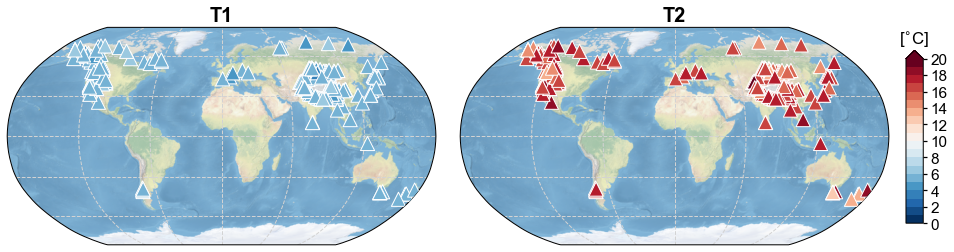

Figure saved at: "figs/thresholds_T.pdf"


In [12]:
cmap = 'RdBu_r'
cbar_title = r'[$^{\circ}$C]'
levels = np.arange(0, 21, 1)
cbar_ticks = np.arange(0, 21, 2)
ms = 200

cmap = plt.get_cmap(cmap)
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
edge_clr = 'w'
marker = '^'
transform = ccrs.PlateCarree()

fig = plt.figure(figsize=(16, 4))
gs = gridspec.GridSpec(1, 2)
gs.update(wspace=0.03, hspace=0)

ax = {}
ax['T1'] = fig.add_subplot(gs[0, 0], projection=ccrs.Robinson())
ax['T1'].stock_img()
im = ax['T1'].scatter(lons, lats, s=ms, c=T1, zorder=99, norm=norm,
    edgecolor=edge_clr, marker=marker, cmap=cmap, transform=transform)
ax['T1'].set_title('T1', fontsize=20, fontweight='bold')
ax['T1'].gridlines()

ax['T2'] = fig.add_subplot(gs[0, 1], projection=ccrs.Robinson())
ax['T2'].stock_img()
im = ax['T2'].scatter(lons, lats, s=ms, c=T2, zorder=99, norm=norm,
    edgecolor=edge_clr, marker=marker, cmap=cmap, transform=transform)
ax['T2'].set_title('T2', fontsize=20, fontweight='bold')
ax['T2'].gridlines()

cax = plt.axes([0.91, 0.2, 0.015, 0.6])
cbar = plt.colorbar(im, cax=cax, extend='max', pad=-0.05)
cbar.set_ticks(cbar_ticks)
cbar.ax.set_title(cbar_title, y=1.05)
cfr.showfig(fig)
cfr.savefig(fig, './figs/thresholds_T.pdf')

In [13]:
cmap = 'BrBG'
cbar_title = '[v/v]'
levels = np.arange(0.0, 0.51, 0.05)
cbar_ticks = np.arange(0.0, 0.51, 0.1)
ms = 200

cmap = plt.get_cmap(cmap)
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
edge_clr = 'w'
marker = '^'
transform = ccrs.PlateCarree()

fig = plt.figure(figsize=(16, 4))
gs = gridspec.GridSpec(1, 2)
gs.update(wspace=0.03, hspace=0)

ax = {}
ax['M1'] = fig.add_subplot(gs[0, 0], projection=ccrs.Robinson())
ax['M1'].stock_img()
im = ax['M1'].scatter(lons, lats, s=ms, c=M1, zorder=99, norm=norm,
    edgecolor=edge_clr, marker=marker, cmap=cmap, transform=transform)
ax['M1'].set_title('M1', fontsize=20, fontweight='bold')
ax['M1'].gridlines()

ax['M2'] = fig.add_subplot(gs[0, 1], projection=ccrs.Robinson())
ax['M2'].stock_img()
im = ax['M2'].scatter(lons, lats, s=ms, c=M2, zorder=99, norm=norm,
    edgecolor=edge_clr, marker=marker, cmap=cmap, transform=transform)
ax['M2'].set_title('M2', fontsize=20, fontweight='bold')
ax['M2'].gridlines()

cax = plt.axes([0.91, 0.2, 0.015, 0.6])
cbar = plt.colorbar(im, cax=cax, extend='max', pad=-0.05)
cbar.set_ticks(cbar_ticks)
cbar.ax.set_title(cbar_title, y=1.05)
cfr.showfig(fig)
cfr.savefig(fig, './figs/thresholds_M.pdf')

Figure saved at: "figs/thresholds_M.pdf"
